In [ ]:
!pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error #no root mean squared error in sklearn
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

In [2]:
#load the data
df = pd.read_csc('co2.csv')

AttributeError: module 'pandas' has no attribute 'read_csc'

In [3]:
df.head()

,sma,pu,peou,trust,Com_op,comtiment,srm
0,3.25,4.75,4.25,3.000000,2.75,2.50,4.75
1,2.50,1.75,2.50,2.666667,2.50,3.50,4.25
2,3.50,2.50,3.75,2.666667,2.75,4.50,3.50
3,4.25,5.00,3.50,3.333333,4.75,4.75,3.75
4,2.75,3.25,2.75,2.666667,1.75,2.50,1.75


In [4]:
#separete the features and the target variable
X = df.drop(columns=['sma'])
y = df['sma']

In [5]:
#split the data into training (70%) and testing(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
#print the test and training
print(f'Training set size: {len(X_train )}')
print(f'Testing set size: {len(X_test)}')

Training set size: 380
Testing set size: 163


In [7]:
#print the test and training  percentage
print(f'Training set percentage: {len(X_train )/len(df)}')
print(f'Testing set percentage: {len(X_test)/len(df)}')

Training set percentage: 0.6998158379373849
Testing set percentage: 0.3001841620626151


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Reshape for LSTM (LSTM expects 3D input: samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [11]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))  # Add dropout to prevent overfitting
lstm_model.add(LSTM(128, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64, activation='tanh', return_sequences=False))
lstm_model.add(Dense(1))  # Regression output

# Compile the LSTM model
history = lstm_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mean_absolute_error'])
# ------------ Grey Wolf Optimizer for Weight Optimization ------------
class GWO:
    def __init__(self, model, X, y, num_wolves=5, max_iter=1500):
        self.model = model
        self.X = X
        self.y = y
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        self.dim = self.model.count_params()
        self.alpha_pos = None
        self.alpha_score = np.inf

    def initialize_wolves(self):
        return [np.random.randn(self.dim) * 0.1 for _ in range(self.num_wolves)]

    def set_weights(self, flat_weights):
        weights = self.model.get_weights()
        shapes = [w.shape for w in weights]
        new_weights, idx = [], 0
        for shape in shapes:
            size = np.prod(shape)
            new_weights.append(flat_weights[idx:idx+size].reshape(shape))
            idx += size
        self.model.set_weights(new_weights)

    def fitness(self, flat_weights):
        self.set_weights(flat_weights)
        pred = self.model.predict(self.X, verbose=0)
        return mean_squared_error(self.y, pred)

    def optimize(self):
        wolves = self.initialize_wolves()

        for iter in range(self.max_iter):
            fitness_values = []
            for wolf in wolves:
                score = self.fitness(wolf)
                fitness_values.append(score)
                if score < self.alpha_score:
                    self.alpha_score = score
                    self.alpha_pos = wolf.copy()

            a = 2 - iter * (2 / self.max_iter)
            new_wolves = []

            for i in range(self.num_wolves):
                A = 2 * a * np.random.rand(self.dim) - a
                C = 2 * np.random.rand(self.dim)
                D_alpha = np.abs(C * self.alpha_pos - wolves[i])
                X1 = self.alpha_pos - A * D_alpha
                new_wolves.append(X1)

            wolves = new_wolves

            if iter % 100 == 0 or iter == self.max_iter - 1:
                print(f"Iteration {iter+1}/{self.max_iter}, Best MSE: {self.alpha_score:.6f}")

        return self.alpha_pos

# Get predictions from the trained LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()  # Flatten to 1D array

c:\Users\Amin Jan\miniconda3\envs\tens_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [13]:
# ------------ Run LSTM-GWO Hybrid Model for Regression ------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def build_deep_lstm(input_shape, units=6, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units//2, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

def run_lstm_gwo_regression(X_train, y_train, lstm_units=6, dropout=0.3, 
                            learning_rate=0.001, wolves=5, iterations=500):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_deep_lstm(input_shape, units=lstm_units, dropout_rate=dropout, learning_rate=learning_rate)
    gwo = GWO(model, X_train, y_train, num_wolves=wolves, max_iter=iterations)
    best_weights = gwo.optimize()
    # Apply optimized weights
    gwo.set_weights(best_weights)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    predictions = model.predict(X_train, verbose=1)
    mse = mean_squared_error(y_train, predictions)
    print("✅ Final Training MSE:", mse)
    return model, predictions

# Train the LSTM-GWO hybrid model and store the training results
lstm_gwo_model, lstm_gwo_train_predictions = run_lstm_gwo_regression(
    X_train_lstm, y_train, 
    lstm_units=6, 
    dropout=0.2, 
    learning_rate=0.001, 
    wolves=5,
    iterations=500
)
  

c:\Users\Amin Jan\miniconda3\envs\tens_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iteration 1/500, Best MSE: 9.612146
Iteration 101/500, Best MSE: 0.985588
Iteration 201/500, Best MSE: 0.865579
Iteration 301/500, Best MSE: 0.592976
Iteration 401/500, Best MSE: 0.546913
Iteration 500/500, Best MSE: 0.533470
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
✅ Final Training MSE: 0.5334695357988145


In [14]:
import matplotlib.pyplot as plt


Epoch 1/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0135 - mean_absolute_error: 0.0849 - val_loss: 0.7949 - val_mean_absolute_error: 0.7763
Epoch 2/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0122 - mean_absolute_error: 0.0814 - val_loss: 0.8242 - val_mean_absolute_error: 0.7855
Epoch 3/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0114 - mean_absolute_error: 0.0795 - val_loss: 0.8343 - val_mean_absolute_error: 0.7845
Epoch 4/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0114 - mean_absolute_error: 0.0785 - val_loss: 0.8448 - val_mean_absolute_error: 0.7850
Epoch 5/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0080 - mean_absolute_error: 0.0679 - val_loss: 0.8292 - val_mean_absolute_error: 0.7737
Epoch 6/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0111 - mean_absolute_error: 0.0813 - val_loss: 0.8457 - val_mean_absolute_error: 0.7766
Epoch 7/1500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0106 - mean_absolute_error: 0.0

Text(0, 0.5, 'Loss (MSE)')

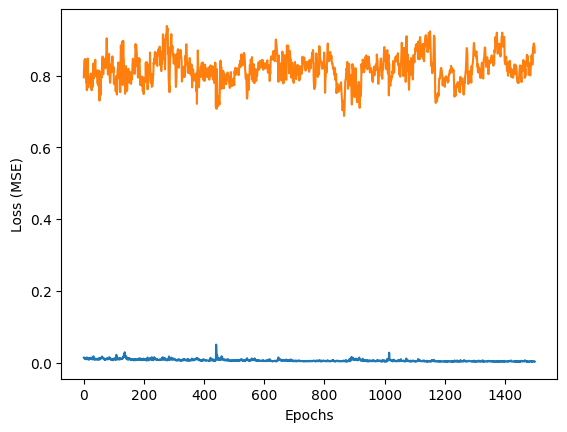

In [17]:

# Train the LSTM model and store the history
history = lstm_model.fit(X_train_lstm, y_train, epochs=1500, batch_size=32, validation_split=0.2)
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

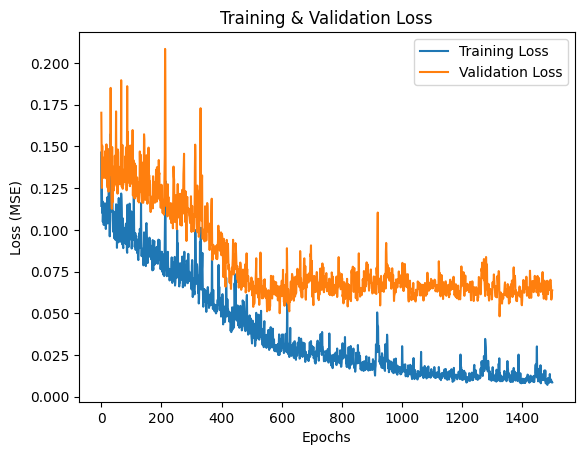

In [23]:
#Write history plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

Model B (dep vs ind)

Main modedl

In [24]:
y_pred = lstm_model.predict(X_test_lstm)  # Predicted values
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error:", mse)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Test Mean Squared Error: 1.218096095739289
MSE: 1.218096095739289
MAE: 0.8627091499925391
R2: 0.0028816425454449845
RMSE: 1.1036739082443188


**ES1V1**

 Model B (trainig)

In [25]:
y_pred = lstm_model.predict(X_train_lstm)  # Predicted values
mse = mean_squared_error(y_train, y_pred)
print("Test Mean Squared Error:", mse)
print('MSE:', mean_squared_error(y_train, y_pred))
print('MAE:', mean_absolute_error(y_train, y_pred))
print('R2:', r2_score(y_train, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Mean Squared Error: 0.38336748712443636
MSE: 0.38336748712443636
MAE: 0.34526530912047937
R2: 0.6842890069946855
RMSE: 0.6191667684270825


In [26]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,541,573 (5.88 MB)

 Trainable params: 513,857 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,027,716 (3.92 MB)

**SHAP ANALYSIS**

In [27]:
import shap
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Amin Jan\miniconda3\envs\tens_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# Define a custom prediction function for LSTM
def lstm_predict(X):
    # Ensure X is a NumPy array and reshape it to 3D
    X = np.array(X)  # Convert to NumPy array if it's a DataFrame
    X_lstm = X.reshape((X.shape[0], 1, X.shape[1]))  # Add the timesteps dimension
    return lstm_model.predict(X_lstm)

In [29]:
# Ensure X_test is in the correct format (Pandas DataFrame)
X_test_np = np.array(X_test)  # Convert X_test to a NumPy array for SHAP

In [30]:
# Create SHAP explainer for the LSTM model
print("Initializing SHAP Explainer for LSTM...")
explainer_lstm = shap.Explainer(lstm_predict, X_test_np)  # Use the custom predict function and 2D features

Initializing SHAP Explainer for LSTM...


In [22]:
# Compute SHAP values for LSTM
print("Computing SHAP values for LSTM...")
shap_values_lstm = explainer_lstm(X_test_np)  # Pass the 2D test data (NumPy array)

Computing SHAP values for LSTM...
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


ExactExplainer explainer:  91%|█████████ | 10/11 [00:00<?, ?it/s]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


ExactExplainer explainer: 12it [00:10,  5.19s/it]                


In [31]:
# Generate SHAP Summary Plot for LSTM
print("Generating SHAP Summary Plot for LSTM...")
shap.summary_plot(shap_values_lstm, X_test, feature_names=X.columns, show=True)

Generating SHAP Summary Plot for LSTM...


NameError: name 'shap_values_lstm' is not defined

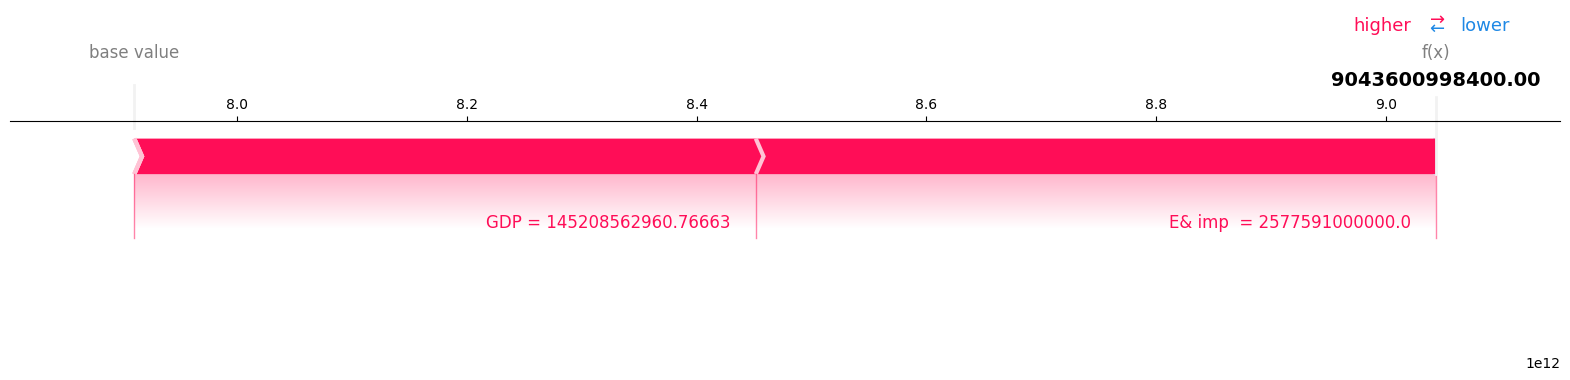

In [24]:
# prompt:  Generate SHAP Force Plot for a single prediction

# Generate SHAP Force Plot for a single prediction
import matplotlib.pyplot as plt

# Choose an instance from the test set (e.g., the first instance)
instance_index = 0

#Instead of explainer_lstm.expected_value, use shap_values_lstm.base_values[instance_index]
# Generate the force plot for the chosen instance
shap.force_plot(shap_values_lstm.base_values[instance_index], shap_values_lstm.values[instance_index,:], X_test.iloc[instance_index,:], show=True, matplotlib=True)


#Optional: Save the plot to a file
#plt.savefig("shap_force_plot.png")


** Perform Sensitivity and Scenario Analysis**

# Features to analyze

In [25]:
!pip install pyswarms # Install a library containing the GWO algorithm

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [27]:

import pyswarms as ps
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the objective function
def my_objective_function(x):
    return np.sum(x**2)  # The function we want to minimize

# 2. Sensitivity Analysis
def sensitivity_analysis():
    population_sizes = [10, 20, 30, 40, 50]  # Test these population sizes
    results = []
    for PopSize in population_sizes:
        # Run GWO with each population size
        # Initialize GWO optimizer
        optimizer = ps.single.GlobalBestPSO(n_particles=PopSize, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=([0, 0], [1, 1]))
        # Perform optimization
        best_cost, best_pos = optimizer.optimize(my_objective_function, iters=100)
        results.append({'Population Size': PopSize, 'Best Score': best_cost}) #Store best cost
    # Plot the results
    sns.boxplot(x='Population Size', y='Best Score', data=pd.DataFrame(results))
    plt.title('Sensitivity Analysis: Population Size vs. Best Score')
    plt.show()



In [ ]:

import pyswarms as ps
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the objective function
def my_objective_function(x):
    return np.sum(x**2)  # The function we want to minimize

# 2. Sensitivity Analysis
def sensitivity_analysis():
    population_sizes = [10, 20, 30, 40, 50]  # Test these population sizes
    results = []
    for PopSize in population_sizes:
        # Run GWO with each population size
        # Initialize GWO optimizer using GlobalBestPSO as a proxy for GWO
        # Note: PySwarms does not have a direct GWO implementation.
        # Here, we use GlobalBestPSO as it has similar population-based optimization characteristics.
        optimizer = ps.single.GlobalBestPSO(n_particles=PopSize, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=([0, 0], [1, 1]))
        # Perform optimization
        best_score, best_pos = optimizer.optimize(my_objective_function, iters=100)
        results.append({'Population Size': PopSize, 'Best Score': best_score})
    # Plot the results
    sns.boxplot(x='Population Size', y='Best Score', data=pd.DataFrame(results))
    plt.title('Sensitivity Analysis: Population Size vs. Best Score')
    plt.show()

# 3. Scenario Analysis
def scenario_analysis():
    scenarios = [
        {'Population Size': 10, 'Max Iterations': 50},
        {'Population Size': 30, 'Max Iterations': 150},
        {'Population Size': 50, 'Max Iterations': 200},
    ]
    results = []
    for scenario in scenarios:
        # Run GWO with each scenario
        pop_size = scenario['Population Size']
        max_iter = scenario['Max Iterations']
        # Initialize GWO optimizer using GlobalBestPSO as a proxy for GWO
        optimizer = ps.single.GlobalBestPSO(n_particles=pop_size, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=([0, 0], [1, 1]))
        # Perform optimization
        best_score, best_pos = optimizer.optimize(my_objective_function, iters=max_iter)
        results.append({'Scenario': str(scenario), 'Best Score': best_score})
    # Plot the results
    sns.barplot(x='Scenario', y='Best Score', data=pd.DataFrame(results))
    plt.title('Scenario Analysis: Best Score for Different Scenarios')
    plt.show()

# Run the analyses
sensitivity_analysis()
scenario_analysis()